In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix,
    mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Graduate_School

Mounted at /content/drive/
/content/drive/My Drive/Graduate_School


In [3]:
data = pd.read_csv('nba_playoffdata_combined.csv')

In [4]:
# Data Processing
# Save team name columns
winners = data['Winner'].copy()
losers = data['Loser'].copy()

# Drop unnecessary columns
data.drop(columns=['Winner', 'Loser', 'Winner Team', 'Loser Team'], inplace=True)

# Create net win column (response var)
def compute_net_wins(row):
    win_diff = row['Winner Games Won'] - row['Loser Games Won']

    if row['Winner Seed'] < row['Loser Seed']:
        return win_diff
    else:
        return -win_diff

data['Net Wins'] = data.apply(compute_net_wins, axis=1)

# Drop columns that make 'Net Wins' dependent
data.drop(columns=['Winner Games Won', "Loser Games Won"], inplace=True)
# Create dummy variables for categorical
data = pd.get_dummies(data, drop_first=True)

In [5]:
data.head()

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser TOV,Loser PF,Loser PTS,Net Wins,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2024,1,8,2,241.8,43.9,90.2,0.487,16.5,42.5,...,12.7,17.3,110.1,3,True,False,False,False,False,False
1,2024,4,5,20,241.5,41.8,87.2,0.479,13.5,36.8,...,14.7,19.7,110.5,1,True,False,False,False,False,False
2,2024,6,3,1,240.3,47.0,92.7,0.507,13.2,35.3,...,12.9,19.2,119.0,-2,True,False,False,False,False,False
3,2024,2,7,19,240.6,41.3,88.7,0.465,13.2,35.8,...,12.0,20.3,114.6,2,True,False,False,False,False,False
4,2024,1,8,3,241.5,44.5,89.3,0.499,13.3,34.2,...,13.0,18.4,115.1,4,False,False,False,False,True,False


In [ ]:
data.columns

Index(['Year', 'Winner Seed', 'Loser Seed', 'Winner Rk', 'Winner MP',
       'Winner FG', 'Winner FGA', 'Winner FG%', 'Winner 3P', 'Winner 3PA',
       'Winner 3P%', 'Winner 2P', 'Winner 2PA', 'Winner 2P%', 'Winner FT',
       'Winner FTA', 'Winner FT%', 'Winner ORB', 'Winner DRB', 'Winner TRB',
       'Winner AST', 'Winner STL', 'Winner BLK', 'Winner TOV', 'Winner PF',
       'Winner PTS', 'Loser Rk', 'Loser MP', 'Loser FG', 'Loser FGA',
       'Loser FG%', 'Loser 3P', 'Loser 3PA', 'Loser 3P%', 'Loser 2P',
       'Loser 2PA', 'Loser 2P%', 'Loser FT', 'Loser FTA', 'Loser FT%',
       'Loser ORB', 'Loser DRB', 'Loser TRB', 'Loser AST', 'Loser STL',
       'Loser BLK', 'Loser TOV', 'Loser PF', 'Loser PTS', 'Net Wins',
       'Round_Eastern Conf First Round', 'Round_Eastern Conf Semifinals',
       'Round_Finals', 'Round_Western Conf Finals',
       'Round_Western Conf First Round', 'Round_Western Conf Semifinals'],
      dtype='object')

In [6]:
df = data.copy()
mask = df['Loser Seed'] < df['Winner Seed']
winner_cols = [col for col in df.columns if col.startswith('Winner')]
loser_cols = [col for col in df.columns if col.startswith('Loser')]

# Sanity check — they should be in the same order logically
assert len(winner_cols) == len(loser_cols)

# Swap values for rows where loser had lower seed
for w_col, l_col in zip(winner_cols, loser_cols):
    temp = df.loc[mask, w_col].copy()
    df.loc[mask, w_col] = df.loc[mask, l_col]
    df.loc[mask, l_col] = temp
df.columns = df.columns.str.replace('Winner ', 'Lower Seed ')
df.columns = df.columns.str.replace('Loser ', 'Higher Seed ')
df = df.rename(columns={'Lower Seed Seed': 'Lower Seed'})
df = df.rename(columns={'Higher Seed Seed': 'Higher Seed'})

In [ ]:
df.to_csv('nba_processed.csv', index=False)

In [7]:
df.head()

,Year,Lower Seed,Higher Seed,Lower Seed Rk,Lower Seed MP,Lower Seed FG,Lower Seed FGA,Lower Seed FG%,Lower Seed 3P,Lower Seed 3PA,...,Higher Seed TOV,Higher Seed PF,Higher Seed PTS,Net Wins,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2024,1,8,2,241.8,43.9,90.2,0.487,16.5,42.5,...,12.7,17.3,110.1,3,True,False,False,False,False,False
1,2024,4,5,20,241.5,41.8,87.2,0.479,13.5,36.8,...,14.7,19.7,110.5,1,True,False,False,False,False,False
2,2024,3,6,4,241.5,43.1,88.5,0.487,14.2,38.1,...,12.9,21.4,123.3,-2,True,False,False,False,False,False
3,2024,2,7,19,240.6,41.3,88.7,0.465,13.2,35.8,...,12.0,20.3,114.6,2,True,False,False,False,False,False
4,2024,1,8,3,241.5,44.5,89.3,0.499,13.3,34.2,...,13.0,18.4,115.1,4,False,False,False,False,True,False


In [10]:
data2025 = pd.read_csv('nba_playoffdata_2025.csv')
data2025

,Year,Round,Match,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,...,Loser FT%,Loser ORB,Loser DRB,Loser TRB,Loser AST,Loser STL,Loser BLK,Loser TOV,Loser PF,Loser PTS
0,2025,Eastern Conf First Round,Indiana Pacers VS Milwaukee Bucks,4,5,7,242.1,43.6,89.3,0.488,...,0.750,8.2,35.1,43.4,25.5,7.3,4.7,13.4,17.9,115.5
1,2025,Eastern Conf First Round,New York Knicks VS Detroit Pistons,3,6,9,242.4,43.3,89.2,0.486,...,0.774,11.4,33.4,44.8,26.4,8.0,5.3,14.9,20.7,115.5
2,2025,Eastern Conf First Round,Boston Celtics VS Orlando Magic,2,7,8,241.8,41.6,90.0,0.462,...,0.775,11.1,30.7,41.8,23.0,8.9,6.0,14.2,20.1,105.4
3,2025,Eastern Conf First Round,Cleveland Cavaliers VS Miami Heat,1,8,1,240.9,44.5,90.8,0.491,...,0.791,9.7,33.7,43.4,26.4,8.1,3.8,13.6,15.5,110.6
4,2025,Western Conf First Round,Oklahoma City Thunder VS Memphis Grizzlies,1,8,4,240.3,44.6,92.7,0.482,...,0.786,12.9,34.4,47.3,28.4,8.9,5.6,15.7,20.9,121.7
5,2025,Western Conf First Round,Denver Nuggets VS Los Angeles Clippers,4,5,3,242.1,45.4,89.8,0.506,...,0.797,10.3,33.5,43.8,25.2,9.4,4.5,14.9,18.3,112.9
6,2025,Western Conf First Round,Los Angeles Lakers VS Minnesota Timberwolves,3,6,19,240.6,40.9,85.5,0.479,...,0.789,11.1,33.2,44.3,26.1,8.0,5.0,14.5,18.3,114.3
7,2025,Western Conf First Round,Golden State Warriors VS Houston Rockets,2,7,17,240.6,40.8,90.4,0.451,...,0.738,14.6,33.8,48.5,23.3,8.4,5.0,13.9,19.0,114.3


In [11]:
data2025 = data2025.drop(columns=['Round','Match'])
data2025['Round_Eastern Conf First Round'] = 0
data2025['Round_Eastern Conf Semifinals'] = 0
data2025['Round_Finals'] = 0
data2025['Round_Western Conf Finals'] = 0
data2025['Round_Western Conf First Round'] = 0
data2025['Round_Western Conf Semifinals'] = 0
data2025.head()

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser BLK,Loser TOV,Loser PF,Loser PTS,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2025,4,5,7,242.1,43.6,89.3,0.488,13.2,35.8,...,4.7,13.4,17.9,115.5,0,0,0,0,0,0
1,2025,3,6,9,242.4,43.3,89.2,0.486,12.6,34.1,...,5.3,14.9,20.7,115.5,0,0,0,0,0,0
2,2025,2,7,8,241.8,41.6,90.0,0.462,17.8,48.2,...,6.0,14.2,20.1,105.4,0,0,0,0,0,0
3,2025,1,8,1,240.9,44.5,90.8,0.491,15.9,41.5,...,3.8,13.6,15.5,110.6,0,0,0,0,0,0
4,2025,1,8,4,240.3,44.6,92.7,0.482,14.5,38.8,...,5.6,15.7,20.9,121.7,0,0,0,0,0,0


In [14]:
data2025.loc[0:3,'Round_Eastern Conf First Round'] = 1
data2025.loc[4:8,'Round_Western Conf First Round'] = 1
X_2025 = np.asarray(data2025)

In [15]:
X_2025

array([[2.025e+03, 4.000e+00, 5.000e+00, 7.000e+00, 2.421e+02, 4.360e+01,
        8.930e+01, 4.880e-01, 1.320e+01, 3.580e+01, 3.680e-01, 3.040e+01,
        5.360e+01, 5.680e-01, 1.700e+01, 2.160e+01, 7.890e-01, 9.200e+00,
        3.270e+01, 4.180e+01, 2.920e+01, 8.500e+00, 5.500e+00, 1.320e+01,
        1.870e+01, 1.174e+02, 1.100e+01, 2.409e+02, 4.200e+01, 8.640e+01,
        4.860e-01, 1.420e+01, 3.660e+01, 3.870e-01, 2.790e+01, 4.970e+01,
        5.600e-01, 1.730e+01, 2.310e+01, 7.500e-01, 8.200e+00, 3.510e+01,
        4.340e+01, 2.550e+01, 7.300e+00, 4.700e+00, 1.340e+01, 1.790e+01,
        1.155e+02, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.025e+03, 3.000e+00, 6.000e+00, 9.000e+00, 2.424e+02, 4.330e+01,
        8.920e+01, 4.860e-01, 1.260e+01, 3.410e+01, 3.690e-01, 3.080e+01,
        5.510e+01, 5.580e-01, 1.650e+01, 2.070e+01, 8.000e-01, 1.090e+01,
        3.180e+01, 4.260e+01, 2.750e+01, 8.200e+00, 4.000e+00, 1.330e+01,
        1.720e+01,

In [16]:
# Train-test split
X = df.drop('Net Wins', axis=1)
y = df['Net Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)

print(X_train.shape)
print(X_test.shape)

(459, 55)
(197, 55)


In [17]:
X_train = X_train.astype('int')
y_train = y_train.astype('category')
y_test = y_test.astype('category')
y_train.dtype
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
x_test = np.asarray(X_test)

In [319]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
mod_log = OrderedModel(y_train,
                        X_train,
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -798.89
Model:                   OrderedModel   AIC:                             1722.
Method:            Maximum Likelihood   BIC:                             1978.
Date:                Sat, 26 Apr 2025                                         
Time:                        19:34:24                                         
No. Observations:                 459                                         
Df Residuals:                     397                                         
Df Model:                          55                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0317        nan        nan        nan         nan         nan
x2            -0.4755        nan        nan        nan         nan         nan
x3             0.2540        nan        nan        nan         nan         nan
x4            -0.0506        nan        nan        nan         nan         nan
x5             0.0606        nan        nan        nan         nan         nan
x6            -0.3745        nan        nan        nan         nan         nan
x7            -0.4173        nan        nan        nan         nan         nan
const               0        nan        nan        nan         nan         nan
x8            -0.0500        nan        nan        nan         nan         nan
x9             0.2559        nan        nan        nan         nan         nan
x10                 0        nan        nan        nan         nan         nan
x11            0.1808        nan        nan        nan         nan         nan
x12            0.2663        nan        nan        nan         nan         nan
x13                 0        nan        nan        nan         nan         nan
x14           -0.3519        nan        nan        nan         nan         nan
x15            0.0353        nan        nan        nan         nan         nan
x16                 0        nan        nan        nan         nan         nan
x17            0.3002        nan        nan        nan         nan         nan
x18            0.2861        nan        nan        nan         nan         nan
x19           -0.1685        nan        nan        nan         nan         nan
x20           -0.0390        nan        nan        nan         nan         nan
x21            0.0805        nan        nan        nan         nan         nan
x22            0.1258        nan        nan        nan         nan         nan
x23           -0.1681        nan        nan        nan         nan         nan
x24            0.0459        nan        nan        nan         nan         nan
x25            0.2059        nan        nan        nan         nan         nan
x26            0.0130        nan        nan        nan         nan         nan
x27           -0.0707        nan        nan        nan         nan         nan
x28            0.2755        nan        nan        nan         nan         nan
x29            0.4785        nan        nan        nan         nan         nan
x30                 0        nan        nan        nan         nan         nan
x31           -0.1757        nan        nan        nan         nan         nan
x32           -0.3751        nan        nan        nan         nan         nan
x33                 0        nan        nan        nan         nan         nan
x34           -0.3683        nan        nan        nan         nan         nan
x35           -0.2890        nan        nan        nan         nan         nan
x36                 0        nan        nan        nan         nan         nan
x3

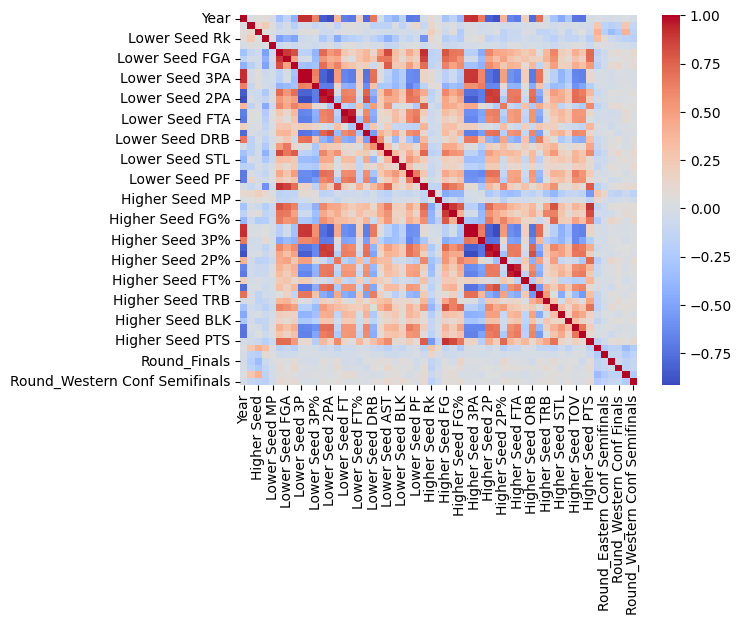

In [ ]:
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.show()

In [18]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=43309cd4c8ccfbc03f54356ba5a6a56ce539b33c396fce282697490753c47983
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
y_train

array([ 4,  4, -2,  2,  2,  3,  2,  1, -2,  2, -2,  2,  1, -3,  3, -1,  3,
        1,  3,  2,  2, -1,  2, -2,  3,  3,  2, -1, -1,  1, -2,  1,  2,  2,
        2,  4, -1, -2,  4,  4, -3, -2,  3, -1,  2,  2,  1, -1, -1,  1,  1,
        3, -2,  4, -2, -3, -2,  4,  2, -1,  3,  4,  3, -3,  3,  2, -2,  3,
       -4, -3,  3,  2,  3,  1,  3, -4,  3,  1, -2, -3,  3, -2, -2, -4,  2,
        4, -3,  1,  1,  1,  3,  2,  3, -2,  4,  1,  2,  3,  3, -2,  4,  4,
       -1, -1,  1, -4,  3,  4,  2,  1, -2,  2, -2,  4,  1,  3,  4, -4,  2,
        2,  1,  4,  1, -3,  3,  3,  2,  3, -2,  2,  2, -1,  2,  1,  2,  4,
       -2, -3, -1,  1,  1, -1,  3, -2, -2,  2,  1,  3,  1,  3, -1,  3,  3,
        2, -1,  1,  3,  4,  2,  1,  1,  1,  2,  3, -2, -1,  2,  3,  4, -1,
        3,  3,  2, -1,  4,  3, -2, -2,  2,  3,  2,  3,  1, -1,  3, -3, -3,
       -2, -3,  2, -1,  2,  1,  4, -3, -2, -1, -2,  3, -1, -2,  1,  2,  3,
        2,  2,  4,  3, -1,  4, -1,  3,  2,  3, -2,  1,  1, -2,  4,  1, -2,
        2,  3,  3, -3,  3

In [19]:
mapping = np.vectorize({
    -4: 0, -3: 1, -2: 2, -1: 3,
     1: 4,  2: 5,  3: 6,  4: 7
}.get)

y_train = mapping(y_train)
y_test = mapping(y_test)

In [20]:
import mord as m
model = m.LogisticAT()  # or LogisticIT, OrdinalRidge, etc.
model.fit(X_train, y_train)
p_test = model.predict(X_test)
p_train = model.predict(X_train)

In [339]:
X.columns

Index(['Year', 'Lower Seed', 'Higher Seed', 'Lower Seed Rk', 'Lower Seed MP',
       'Lower Seed FG', 'Lower Seed FGA', 'Lower Seed FG%', 'Lower Seed 3P',
       'Lower Seed 3PA', 'Lower Seed 3P%', 'Lower Seed 2P', 'Lower Seed 2PA',
       'Lower Seed 2P%', 'Lower Seed FT', 'Lower Seed FTA', 'Lower Seed FT%',
       'Lower Seed ORB', 'Lower Seed DRB', 'Lower Seed TRB', 'Lower Seed AST',
       'Lower Seed STL', 'Lower Seed BLK', 'Lower Seed TOV', 'Lower Seed PF',
       'Lower Seed PTS', 'Higher Seed Rk', 'Higher Seed MP', 'Higher Seed FG',
       'Higher Seed FGA', 'Higher Seed FG%', 'Higher Seed 3P',
       'Higher Seed 3PA', 'Higher Seed 3P%', 'Higher Seed 2P',
       'Higher Seed 2PA', 'Higher Seed 2P%', 'Higher Seed FT',
       'Higher Seed FTA', 'Higher Seed FT%', 'Higher Seed ORB',
       'Higher Seed DRB', 'Higher Seed TRB', 'Higher Seed AST',
       'Higher Seed STL', 'Higher Seed BLK', 'Higher Seed TOV',
       'Higher Seed PF', 'Higher Seed PTS', 'Round_Eastern Conf First Ro

In [338]:
model.coef_

array([-5.05035065e-03, -3.48268683e-01,  4.12936524e-01, -4.78254755e-02,
        1.38557829e-01, -7.53448406e-02, -3.58864596e-01,  0.00000000e+00,
        8.33848653e-02,  5.83311361e-02,  0.00000000e+00,  8.24510420e-02,
        1.20991470e-01,  0.00000000e+00, -3.58087486e-01,  5.54203555e-02,
        0.00000000e+00,  9.78755998e-02,  1.32749254e-01,  7.08196708e-02,
        1.47621128e-04,  2.25534052e-01,  6.68466902e-02, -2.92673642e-01,
        4.58040043e-02,  1.60871408e-01,  2.64344834e-03, -9.72554853e-02,
        1.35242373e-01,  3.93119630e-01,  0.00000000e+00, -2.50542799e-01,
       -2.09594008e-01,  0.00000000e+00, -3.54393392e-01, -1.45528239e-01,
        0.00000000e+00, -2.57513619e-01,  2.38373089e-01,  0.00000000e+00,
       -1.32245488e-02,  1.86024528e-01, -2.31240973e-01, -1.23200530e-01,
        3.13311996e-01, -1.17594887e-01, -1.59052631e-02, -1.81785272e-02,
       -1.72158569e-02,  2.76697384e-01,  2.51233249e-01, -3.01978610e-01,
        6.40140822e-02,  

In [21]:
coeffs = model.coef_
abs_coefficients = np.abs(coeffs)
top5 = np.argsort(abs_coefficients)[-5:]
top5 = X.columns[top5]
print(top5)

Index(['Higher Seed 2P', 'Lower Seed FT', 'Lower Seed FGA', 'Higher Seed FGA',
       'Higher Seed'],
      dtype='object')


In [22]:
inverse_mapping = np.vectorize({
    0: -4, 1: -3, 2: -2, 3: -1,
     4: 1,  5: 2,  6: 3,  7:4
}.get)

In [23]:
p_train = inverse_mapping(p_train)
y_train = inverse_mapping(y_train)
p_test = inverse_mapping(p_test)
y_test = inverse_mapping(y_test)
mse = np.sum((p_train - y_train)**2)/len(y_train)
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",mse)
mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",mse)

Train ACC:  0.24618736383442266
Train MSE:  3.962962962962963
Test ACC: 0.20812182741116753
Test MSE:  5.213197969543147


In [25]:
pred_2025 = model.predict(X_2025)
pred_2025 = inverse_mapping(pred_2025)
print(pred_2025)

[ 2  2  3  3  3  2 -1  2]


In [27]:
# Pacers v Bucks: pacers in 4-2
# Knicks v Pistons: knicks in 4-2
# Celtics v Magic: celtics in 4-1
# Cavs v Heat: cavs in 4-1
# Thunder v Grizz: thunder in 4-1
# Nuggets v Clippers: nuggets in 4-2
# Lakers v Wolves: wolves in 4-3
# Rockets v Warriors: rockets in 4-2

,Year,Winner Seed,Loser Seed,Winner Rk,Winner MP,Winner FG,Winner FGA,Winner FG%,Winner 3P,Winner 3PA,...,Loser BLK,Loser TOV,Loser PF,Loser PTS,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
0,2025,4,5,7,242.1,43.6,89.3,0.488,13.2,35.8,...,4.7,13.4,17.9,115.5,1,0,0,0,0,0
1,2025,3,6,9,242.4,43.3,89.2,0.486,12.6,34.1,...,5.3,14.9,20.7,115.5,1,0,0,0,0,0
2,2025,2,7,8,241.8,41.6,90.0,0.462,17.8,48.2,...,6.0,14.2,20.1,105.4,1,0,0,0,0,0
3,2025,1,8,1,240.9,44.5,90.8,0.491,15.9,41.5,...,3.8,13.6,15.5,110.6,1,0,0,0,0,0
4,2025,1,8,4,240.3,44.6,92.7,0.482,14.5,38.8,...,5.6,15.7,20.9,121.7,0,0,0,0,1,0
5,2025,4,5,3,242.1,45.4,89.8,0.506,12.0,31.9,...,4.5,14.9,18.3,112.9,0,0,0,0,1,0
6,2025,3,6,19,240.6,40.9,85.5,0.479,13.3,36.4,...,5.0,14.5,18.3,114.3,0,0,0,0,1,0
7,2025,2,7,17,240.6,40.8,90.4,0.451,15.4,42.4,...,5.0,13.9,19.0,114.3,0,0,0,0,1,0


In [342]:
y_train

array([ 4,  4, -2,  2,  2,  3,  2,  1, -2,  2, -2,  2,  1, -3,  3, -1,  3,
        1,  3,  2,  2, -1,  2, -2,  3,  3,  2, -1, -1,  1, -2,  1,  2,  2,
        2,  4, -1, -2,  4,  4, -3, -2,  3, -1,  2,  2,  1, -1, -1,  1,  1,
        3, -2,  4, -2, -3, -2,  4,  2, -1,  3,  4,  3, -3,  3,  2, -2,  3,
       -4, -3,  3,  2,  3,  1,  3, -4,  3,  1, -2, -3,  3, -2, -2, -4,  2,
        4, -3,  1,  1,  1,  3,  2,  3, -2,  4,  1,  2,  3,  3, -2,  4,  4,
       -1, -1,  1, -4,  3,  4,  2,  1, -2,  2, -2,  4,  1,  3,  4, -4,  2,
        2,  1,  4,  1, -3,  3,  3,  2,  3, -2,  2,  2, -1,  2,  1,  2,  4,
       -2, -3, -1,  1,  1, -1,  3, -2, -2,  2,  1,  3,  1,  3, -1,  3,  3,
        2, -1,  1,  3,  4,  2,  1,  1,  1,  2,  3, -2, -1,  2,  3,  4, -1,
        3,  3,  2, -1,  4,  3, -2, -2,  2,  3,  2,  3,  1, -1,  3, -3, -3,
       -2, -3,  2, -1,  2,  1,  4, -3, -2, -1, -2,  3, -1, -2,  1,  2,  3,
        2,  2,  4,  3, -1,  4, -1,  3,  2,  3, -2,  1,  1, -2,  4,  1, -2,
        2,  3,  3, -3,  3

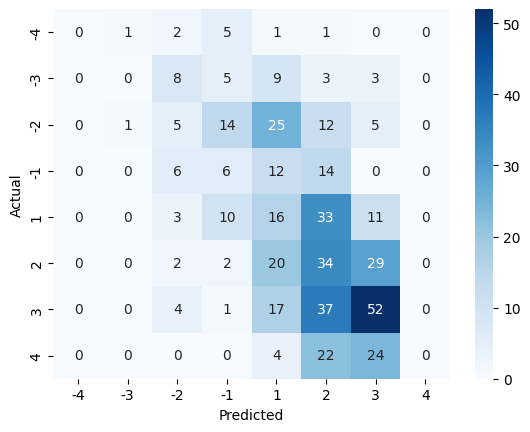

In [343]:
cm = confusion_matrix(y_train, p_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
p_train = model.predict(X_train)
mse = np.sum((p_train - y_train)**2)/len(y_train)
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",mse)
p_test = model.predict(X_test)
mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",mse)

Train ACC:  0.35076252723311546
Train MSE:  5.958605664488018
Test ACC: 0.2233502538071066
Test MSE:  6.517766497461929


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
train_predicted = res_log.model.predict(res_log.params, exog=X_train)
p_train = np.argmax(train_predicted,axis=1)
p_train[p_train == 0] = -4
p_train[p_train == 1] = -3
p_train[p_train == 2] = -2
p_train[p_train == 3] = -1
p_train[p_train == 4] = 1
p_train[p_train == 5] = 2
p_train[p_train == 6] = 3
p_train[p_train == 7] = 4


In [ ]:
mse = np.sum((p_train - y_train)**2)/len(y_train)
acc = accuracy_score(p_train,y_train)
print(acc)
print(mse)

0.3006535947712418
5.302832244008715


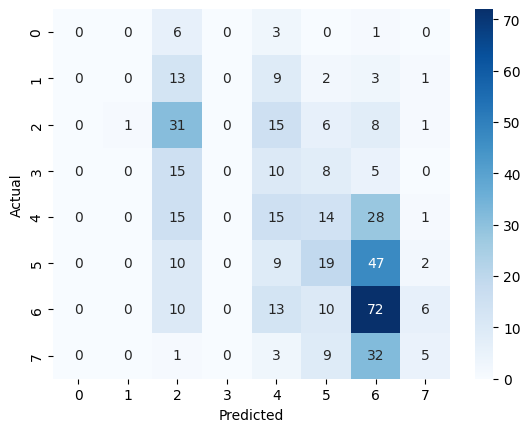

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, p_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
X_test= X_test.astype('int')
test_predicted = res_log.model.predict(res_log.params, exog=X_test)
p_test = np.argmax(test_predicted,axis=1)
p_test.shape

(197,)

In [ ]:
p_test[p_test == 0] = -4
p_test[p_test == 1] = -3
p_test[p_test == 2] = -2
p_test[p_test == 3] = -1
p_test[p_test == 4] = 1
p_test[p_test == 5] = 2
p_test[p_test == 6] = 3
p_test[p_test == 7] = 4

In [ ]:
mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print(mse)
print(acc)

5.903553299492386
0.23857868020304568


In [ ]:
p_test

array([6, 2, 5, 6, 4, 6, 2, 6, 6, 6, 4, 5, 4, 2, 2, 6, 5, 2, 2, 6, 2, 6,
       5, 6, 6, 6, 6, 2, 4, 6, 4, 2, 6, 6, 5, 2, 6, 2, 6, 6, 5, 4, 1, 5,
       6, 5, 5, 7, 5, 6, 2, 5, 5, 6, 5, 6, 6, 4, 6, 7, 4, 2, 5, 6, 5, 6,
       2, 4, 6, 2, 6, 2, 4, 6, 2, 6, 6, 4, 2, 6, 4, 6, 5, 6, 2, 6, 2, 2,
       6, 2, 2, 2, 6, 6, 2, 6, 5, 2, 6, 6, 6, 6, 4, 6, 6, 6, 4, 6, 7, 2,
       6, 2, 5, 6, 2, 6, 2, 6, 5, 5, 2, 2, 5, 2, 7, 6, 6, 2, 6, 2, 2, 6,
       4, 5, 6, 4, 6, 4, 2, 4, 6, 6, 4, 6, 5, 4, 7, 4, 6, 2, 6, 4, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 6, 6, 2, 2, 6, 6, 6, 5, 4, 6, 6, 5,
       2, 6, 6, 5, 4, 2, 5, 6, 2, 4, 2, 4, 4, 5, 4, 2, 6, 5, 6, 6, 5])

In [ ]:
y_test

array([ 3,  2,  1, -2,  1,  3,  1, -1,  3,  2,  4,  4,  2, -2,  3,  2,  3,
       -1,  1, -2,  2,  3, -1,  3, -2,  3,  1, -1, -2,  2,  3,  2,  1,  4,
        2,  2,  3,  3,  2,  1,  3,  1, -2,  1, -1,  1,  4,  2,  3, -2, -1,
        1, -2, -1, -1,  2,  3,  2,  3,  2, -1, -2,  2,  1,  1,  2,  1,  4,
       -1,  3,  2,  4,  1,  4,  3,  4,  2,  3, -3,  1, -1,  1,  2,  4, -1,
        4, -2,  2,  3,  3, -1, -4,  3,  2,  3,  4,  4,  1,  3,  3,  3, -1,
        1,  1,  3,  2,  3,  3,  4, -2,  2,  2, -2,  3, -1,  3,  2,  3,  3,
        4, -1,  1,  2, -1,  3, -2,  3, -1,  4, -4, -4, -1,  4, -3,  2, -3,
        3,  2,  2,  2,  2,  1,  1,  2,  1, -1, -2, -2,  3,  1,  1, -3,  2,
        2, -2,  3,  1,  4, -1,  3,  3,  1,  2,  4,  1,  3, -2,  1,  1,  2,
        1,  2,  2,  3,  3,  1, -2, -4, -2, -2,  1, -4, -1,  2,  3,  4,  1,
       -4, -2,  3, -2,  1,  2,  2, -2, -2,  2])

In [ ]:
X_test

,Year,Lower Seed,Higher Seed,Lower Seed Rk,Lower Seed MP,Lower Seed FG,Lower Seed FGA,Lower Seed FG%,Lower Seed 3P,Lower Seed 3PA,...,Higher Seed BLK,Higher Seed TOV,Higher Seed PF,Higher Seed PTS,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals
503,1991,1,5,3,242,43,89,0,4,11,...,5,15,21,104,0,0,0,0,0,1
520,1990,3,5,4,242,43,92,0,2,6,...,6,15,22,114,0,0,0,1,0,0
411,1997,2,7,4,241,36,78,0,6,19,...,3,14,21,102,0,0,0,0,1,0
615,1983,4,5,10,241,43,88,0,0,1,...,4,18,23,107,0,0,0,0,1,0
576,1986,2,3,5,241,43,89,0,1,4,...,6,19,21,110,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,1984,2,6,18,242,41,85,0,0,2,...,6,19,27,110,0,1,0,0,0,0
247,2008,4,5,5,240,40,80,0,5,13,...,5,13,19,96,0,0,0,0,1,0
387,1999,2,8,6,242,34,77,0,5,16,...,5,16,22,86,0,0,0,0,0,0
171,2013,3,6,1,242,40,85,0,6,18,...,4,15,21,101,0,0,0,0,1,0


In [ ]:
df.columns

Index(['Year', 'Lower Seed', 'Higher Seed', 'Lower Seed Rk', 'Lower Seed MP',
       'Lower Seed FG', 'Lower Seed FGA', 'Lower Seed FG%', 'Lower Seed 3P',
       'Lower Seed 3PA', 'Lower Seed 3P%', 'Lower Seed 2P', 'Lower Seed 2PA',
       'Lower Seed 2P%', 'Lower Seed FT', 'Lower Seed FTA', 'Lower Seed FT%',
       'Lower Seed ORB', 'Lower Seed DRB', 'Lower Seed TRB', 'Lower Seed AST',
       'Lower Seed STL', 'Lower Seed BLK', 'Lower Seed TOV', 'Lower Seed PF',
       'Lower Seed PTS', 'Higher Seed Rk', 'Higher Seed MP', 'Higher Seed FG',
       'Higher Seed FGA', 'Higher Seed FG%', 'Higher Seed 3P',
       'Higher Seed 3PA', 'Higher Seed 3P%', 'Higher Seed 2P',
       'Higher Seed 2PA', 'Higher Seed 2P%', 'Higher Seed FT',
       'Higher Seed FTA', 'Higher Seed FT%', 'Higher Seed ORB',
       'Higher Seed DRB', 'Higher Seed TRB', 'Higher Seed AST',
       'Higher Seed STL', 'Higher Seed BLK', 'Higher Seed TOV',
       'Higher Seed PF', 'Higher Seed PTS', 'Net Wins',
       'Round_Ea

In [ ]:
df['MP Diff'] = df['Lower Seed MP'] - df['Higher Seed MP']
df['FG Diff'] = df['Lower Seed FG'] - df['Higher Seed FG']
df['FGA Diff'] = df['Lower Seed FGA'] - df['Higher Seed FGA']
df['FG% Diff'] = df['Lower Seed FG%'] - df['Higher Seed FG%']
df['3P Diff'] = df['Lower Seed 3P'] - df['Higher Seed 3P']
df['3PA Diff'] = df['Lower Seed 3PA'] - df['Higher Seed 3PA']
df['3P% Diff'] = df['Lower Seed 3P%'] - df['Higher Seed 3P%']
df['2P Diff'] = df['Lower Seed 2P'] - df['Higher Seed 2P']
df['2PA Diff'] = df['Lower Seed 2PA'] - df['Higher Seed 2PA']
df['2P% Diff'] = df['Lower Seed 2P%'] - df['Higher Seed 2P%']
df['FT Diff'] = df['Lower Seed FT'] - df['Higher Seed FT']
df['FTA Diff'] = df['Lower Seed FTA'] - df['Higher Seed FTA']
df['FT% Diff'] = df['Lower Seed FT%'] - df['Higher Seed FT%']
df['ORB Diff'] = df['Lower Seed ORB'] - df['Higher Seed ORB']
df['DRB Diff'] = df['Lower Seed DRB'] - df['Higher Seed DRB']
df['TRB Diff'] = df['Lower Seed TRB'] - df['Higher Seed TRB']
df['AST Diff'] = df['Lower Seed AST'] - df['Higher Seed AST']
df['STL Diff'] = df['Lower Seed STL'] - df['Higher Seed STL']
df['BLK Diff'] = df['Lower Seed BLK'] - df['Higher Seed BLK']
df['TOV Diff'] = df['Lower Seed TOV'] - df['Higher Seed TOV']
df['PF Diff'] = df['Lower Seed PF'] - df['Higher Seed PF']
df['PTS Diff'] = df['Lower Seed PTS'] - df['Higher Seed PTS']

In [ ]:
df = df.drop(columns=['Lower Seed Rk', 'Lower Seed MP',
       'Lower Seed FG', 'Lower Seed FGA', 'Lower Seed FG%', 'Lower Seed 3P',
       'Lower Seed 3PA', 'Lower Seed 3P%', 'Lower Seed 2P', 'Lower Seed 2PA',
       'Lower Seed 2P%', 'Lower Seed FT', 'Lower Seed FTA', 'Lower Seed FT%',
       'Lower Seed ORB', 'Lower Seed DRB', 'Lower Seed TRB', 'Lower Seed AST',
       'Lower Seed STL', 'Lower Seed BLK', 'Lower Seed TOV', 'Lower Seed PF',
       'Lower Seed PTS', 'Higher Seed Rk', 'Higher Seed MP', 'Higher Seed FG',
       'Higher Seed FGA', 'Higher Seed FG%', 'Higher Seed 3P',
       'Higher Seed 3PA', 'Higher Seed 3P%', 'Higher Seed 2P',
       'Higher Seed 2PA', 'Higher Seed 2P%', 'Higher Seed FT',
       'Higher Seed FTA', 'Higher Seed FT%', 'Higher Seed ORB',
       'Higher Seed DRB', 'Higher Seed TRB', 'Higher Seed AST',
       'Higher Seed STL', 'Higher Seed BLK', 'Higher Seed TOV',
       'Higher Seed PF', 'Higher Seed PTS'])


In [ ]:
df.head()

,Year,Lower Seed,Higher Seed,Net Wins,Round_Eastern Conf First Round,Round_Eastern Conf Semifinals,Round_Finals,Round_Western Conf Finals,Round_Western Conf First Round,Round_Western Conf Semifinals,...,FT% Diff,ORB Diff,DRB Diff,TRB Diff,AST Diff,STL Diff,BLK Diff,TOV Diff,PF Diff,PTS Diff
0,2024,1,8,3,True,False,False,False,False,False,...,-0.011,1.4,2.6,4.0,1.1,-0.7,3.2,-0.8,-1.1,10.5
1,2024,4,5,1,True,False,False,False,False,False,...,0.006,-0.7,1.6,1.0,3.3,-0.8,-0.6,-1.1,-2.2,2.1
2,2024,3,6,-2,True,False,False,False,False,False,...,-0.008,-0.7,3.4,2.7,-4.3,-0.9,-0.9,0.0,-2.2,-4.3
3,2024,2,7,2,True,False,False,False,False,False,...,-0.046,1.7,0.6,2.2,-0.5,-1.0,-1.9,1.2,-2.7,-1.8
4,2024,1,8,4,False,False,False,False,True,False,...,0.054,-1.6,-0.4,-2.0,0.1,0.2,2.0,-0.3,0.4,5.0


In [6]:
# Train-test split
X = df.drop('Net Wins', axis=1)
y = df['Net Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)

print(X_train.shape)
print(X_test.shape)

(459, 55)
(197, 55)


In [ ]:
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('category')
y_test = y_test.astype('category')
y_train.dtype
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
x_test = np.asarray(X_test)
from statsmodels.miscmodels.ordinal_model import OrderedModel
mod_log = OrderedModel(y_train,
                        X_train,
                        distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -810.91
Model:                   OrderedModel   AIC:                             1698.
Method:            Maximum Likelihood   BIC:                             1855.
Date:                Sat, 26 Apr 2025                                         
Time:                        04:54:49                                         
No. Observations:                 459                                         
Df Residuals:                     421                                         
Df Model:                          31                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0165        nan        nan        nan         nan         nan
x2            -0.5301        nan        nan        nan         nan         nan
x3             0.2234        nan        nan        nan         nan         nan
x4             1.1747        nan        nan        nan         nan         nan
x5             1.0456        nan        nan        nan         nan         nan
x6             0.2053        nan        nan        nan         nan         nan
x7             0.9303        nan        nan        nan         nan         nan
x8             1.2541        nan        nan        nan         nan         nan
x9             0.9238        nan        nan        nan         nan         nan
x10            0.0124        nan        nan        nan         nan         nan
x11            0.1607        nan        nan        nan         nan         nan
x12           -0.2146        nan        nan        nan         nan         nan
const               0        nan        nan        nan         nan         nan
x13            0.1693        nan        nan        nan         nan         nan
x14            0.1530        nan        nan        nan         nan         nan
x15                 0        nan        nan        nan         nan         nan
x16            0.3437        nan        nan        nan         nan         nan
x17            0.0380        nan        nan        nan         nan         nan
x18                 0        nan        nan        nan         nan         nan
x19            0.2493        nan        nan        nan         nan         nan
x20           -0.1563        nan        nan        nan         nan         nan
x21                 0        nan        nan        nan         nan         nan
x22            0.1463        nan        nan        nan         nan         nan
x23            0.1249        nan        nan        nan         nan         nan
x24           -0.0041        nan        nan        nan         nan         nan
x25           -0.0128        nan        nan        nan         nan         nan
x26           -0.0555        nan        nan        nan         nan         nan
x27            0.0740        nan        nan        nan         nan         nan
x28           -0.0173        nan        nan        nan         nan         nan
x29            0.0432        nan        nan        nan         nan         nan
x30           -0.0659        nan        nan        nan         nan         nan
-4/-3         30.1164        nan        nan        nan         nan         nan
-3/-2          0.3839        nan        nan        nan         nan         nan
-2/-1          0.2521        nan        nan        nan         nan         nan
-1/1          -0.6205        nan        nan        nan         nan         nan
1/2           -0.1385        nan        nan        nan         nan         nan
2/3           -0.0220        nan        nan        nan         nan         nan
3/

In [ ]:
train_predicted = res_log.model.predict(res_log.params, exog=X_train)
p_train = np.argmax(train_predicted,axis=1)
p_train.shape
p_train[p_train == 0] = -4
p_train[p_train == 1] = -3
p_train[p_train == 2] = -2
p_train[p_train == 3] = -1
p_train[p_train == 4] = 1
p_train[p_train == 5] = 2
p_train[p_train == 6] = 3
p_train[p_train == 7] = 4
mse = np.sum((p_train - y_train)**2)/len(y_train)
acc = accuracy_score(p_train,y_train)
print("Train MSE: ",mse)
print("Train acc: ",acc)

Train MSE:  4.675381263616558
Train acc:  0.29411764705882354


In [ ]:
test_predicted = res_log.model.predict(res_log.params, exog=x_test)
p_test = np.argmax(test_predicted,axis=1)
p_test[p_test == 0] = -4
p_test[p_test == 1] = -3
p_test[p_test == 2] = -2
p_test[p_test == 3] = -1
p_test[p_test == 4] = 1
p_test[p_test == 5] = 2
p_test[p_test == 6] = 3
p_test[p_test == 7] = 4
mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print(mse)
print(acc)

5.776649746192893
0.22842639593908629


In [99]:
# Train-test split
X = df.drop('Net Wins', axis=1)
y = df['Net Wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('category')
y_test = y_test.astype('category')
y_train.dtype
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
x_test = np.asarray(X_test)
print(X_train.shape)
print(X_test.shape)

mapping = np.vectorize({
    -4: 0, -3: 1, -2: 2, -1: 3,
     1: 4,  2: 5,  3: 6,  4: 7
}.get)

y_train = mapping(y_train)
y_test = mapping(y_test)


(459, 55)
(197, 55)


In [100]:
y_train_flat = np.zeros((len(y_train), 8))
y_test_flat = np.zeros((len(y_test), 8))
for i in range(len(y_train)):
    y_train_flat[i, 0:int(y_train[i])] = 1
for i in range(len(y_test)):
    y_test_flat[i, 0:int(y_test[i])] = 1

In [159]:
y_train_flat[19]

array([1., 1., 1., 1., 1., 0., 0., 0.])

In [268]:
weight = np.zeros(8)
for i in range(0,8):
 weight[i] = np.sum(y_train == i)/len(y_train)

In [274]:
np.sum(y_train == 4)/len(y_train)

np.float64(0.15904139433551198)

In [276]:
#weight = (1-weight)/weight
#print(weight)

[44.9        15.39285714  6.40322581 11.07894737  5.28767123  4.27586207
  3.13513514  8.18      ]


In [297]:
# prompt: generate a pytorch mlp with 3 layers and then a softmax output for probabilities ]

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from tqdm.notebook import trange
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(55, 40)
        self.fc2 = nn.Linear(40, 16)
        self.fc3 = nn.Linear(16, 8)
        #self.dropout = nn.Dropout(p=0.05)
    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.sigmoid(x) # Apply softmax for probabilities
        return x
    def predict(self, x):
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.sigmoid(x) # Apply softmax for probabilities
        return x


mlp_model = MLP()
print(mlp_model)

# Example input
train_X_ten = torch.tensor(X_train) #Batch size of 1
test_X_ten = torch.tensor(x_test) #Batch size of 1
train_y_ten = torch.tensor(y_train_flat)
test_y_ten = torch.tensor(y_test_flat)
pos_weight = torch.tensor(weight)

traindata = torch.utils.data.TensorDataset(torch.tensor(train_X_ten,dtype=torch.float),torch.tensor(train_y_ten,dtype=torch.float))
trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
testdata = torch.utils.data.TensorDataset(torch.tensor(test_X_ten,dtype=torch.float),torch.tensor(test_y_ten,dtype=torch.float))
testloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)
# Get predictions
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-5)
losstrace = []
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=500, eta_min=0, last_epoch= -1, verbose=False)
mlp_model.train()
for _ in trange(1500):
  for train_batch, test_batch in zip(trainloader,testloader):
    xtrain_batch, ytrain_labels = train_batch
    xtest_batch, ytest_labels = test_batch
    pred = mlp_model(xtrain_batch)
    loss = loss_fn(pred,ytrain_labels)
    #loss = loss_fn(pred,ytrain_labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #scheduler.step()
    losstrace.append(loss.item())


MLP(
  (fc1): Linear(in_features=55, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
)


<ipython-input-297-3c2210ea2ac7>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traindata = torch.utils.data.TensorDataset(torch.tensor(train_X_ten,dtype=torch.float),torch.tensor(train_y_ten,dtype=torch.float))
<ipython-input-297-3c2210ea2ac7>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testdata = torch.utils.data.TensorDataset(torch.tensor(test_X_ten,dtype=torch.float),torch.tensor(test_y_ten,dtype=torch.float))


  0%|          | 0/1500 [00:00<?, ?it/s]

In [188]:
torch.log(torch.tensor(10))

tensor(2.3026)

In [233]:
def CrossEntropyLoss(y_true, y_pred):
    return -torch.sum(y_true*torch.log(y_pred)+ (1 - y_true)*torch.log(1-y_pred))

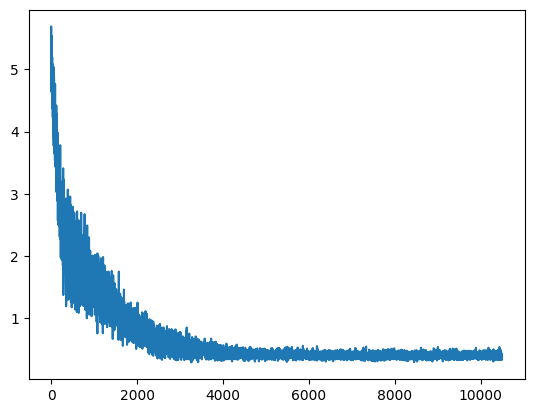

In [298]:
plt.plot(losstrace)

In [299]:
mlp_model.eval()
train_X_ten = torch.tensor(X_train,dtype=torch.float32)
test_X_ten = torch.tensor(x_test,dtype=torch.float32)
train_y_ten = torch.tensor(y_train_flat,dtype=torch.float32)
test_y_ten = torch.tensor(y_test_flat,dtype=torch.float32)
with torch.no_grad():
  p_train = mlp_model.predict(train_X_ten)
  p_test = mlp_model.predict(test_X_ten)

In [182]:
q = -torch.sum(train_y_ten * torch.log(p_train))
print(q)

tensor(14.5799)


In [292]:
p_train[4]

tensor([0.8462, 0.4190, 0.6822, 0.7596, 0.4836, 0.3067, 0.1169, 0.4787])

In [293]:
y_train_flat[4]

array([1., 1., 1., 1., 1., 0., 0., 0.])

In [300]:
p_train = (p_train.numpy() > 0.5).astype(int)
p_test = (p_test.numpy() > 0.5).astype(int)

In [301]:
p_train = np.sum(p_train,axis=1)
p_test = np.sum(p_test,axis=1)

In [303]:
mapping = np.vectorize({
    0: -4, 1:-3, 2:-2, 3:-1,
     4: 1, 5: 2,  6: 3,  7: 4
}.get)
p_train = mapping(p_train)
p_test = mapping(p_test)
y_train = mapping(y_train)
y_test = mapping(y_test)

In [306]:
p_train

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2,

In [310]:
train_mse = mse = np.sum((p_train - y_train)**2)/len(y_train)
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",train_mse)

# p_test is already calculated above, no need to predict again
test_mse = mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",test_mse)

Train ACC:  0.19172113289760348
Train MSE:  5.962962962962963
Test ACC: 0.2182741116751269
Test MSE:  5.269035532994923


In [250]:
def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

In [112]:
mlp_model.eval()
train_X_ten = torch.tensor(X_train,dtype=torch.float32)
test_X_ten = torch.tensor(x_test,dtype=torch.float32)
train_y_ten = torch.tensor(y_train_flat,dtype=torch.float32)
test_y_ten = torch.tensor(y_test_flat,dtype=torch.float32)
with torch.no_grad():
  p_train = mlp_model(train_X_ten)
  p_test = mlp_model(test_X_ten)

# Convert p_train and p_test to numpy arrays and then to the correct dtype
p_train = torch.argmax(p_train, dim=1).cpu().numpy().astype(np.float32)
p_test = torch.argmax(p_test, dim=1).cpu().numpy().astype(np.float32)

# Convert y_train and y_test to the correct dtype if necessary
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

train_mse = mse(torch.tensor(p_train),torch.tensor(y_train)) # Convert to tensors for mse function
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",train_mse)

# p_test is already calculated above, no need to predict again
test_mse = mse(torch.tensor(p_test), torch.tensor(y_test)) # Convert to tensors for mse function
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",test_mse)

Train ACC:  0.02178649237472767
Train MSE:  tensor(22.6732)
Test ACC: 0.030456852791878174
Test MSE:  tensor(22.5330)


In [86]:
p_train

array([2., 4., 4., 2., 4., 2., 4., 4., 4., 2., 4., 2., 4., 2., 4., 2., 4.,
       4., 4., 4., 4., 4., 2., 4., 2., 2., 4., 4., 4., 4., 2., 4., 2., 4.,
       2., 4., 4., 4., 4., 4., 4., 4., 2., 4., 4., 2., 4., 4., 2., 4., 2.,
       4., 4., 4., 4., 4., 2., 2., 4., 4., 2., 2., 4., 4., 2., 4., 4., 4.,
       4., 4., 2., 2., 4., 4., 4., 4., 2., 4., 4., 2., 4., 4., 4., 4., 4.,
       2., 4., 2., 4., 4., 4., 2., 4., 4., 2., 4., 4., 4., 4., 2., 4., 4.,
       4., 4., 4., 4., 2., 2., 4., 4., 4., 2., 2., 2., 4., 4., 4., 4., 2.,
       4., 4., 2., 2., 4., 4., 4., 4., 4., 2., 4., 4., 4., 4., 4., 2., 4.,
       2., 4., 4., 2., 2., 4., 4., 4., 2., 4., 4., 4., 2., 2., 4., 4., 2.,
       4., 4., 4., 4., 4., 4., 4., 2., 2., 4., 4., 4., 2., 4., 2., 4., 4.,
       4., 2., 2., 4., 4., 4., 4., 4., 2., 2., 4., 2., 4., 2., 2., 4., 4.,
       4., 2., 2., 4., 4., 4., 4., 4., 2., 4., 4., 4., 4., 4., 2., 4., 2.,
       2., 4., 4., 4., 4., 2., 2., 4., 4., 4., 4., 2., 4., 2., 4., 4., 4.,
       4., 4., 4., 2., 2.

In [28]:
mlp_model.eval()
train_X_ten = torch.tensor(X_train,dtype=torch.float32)
test_X_ten = torch.tensor(x_test,dtype=torch.float32)
train_y_ten = torch.tensor(y_train_flat,dtype=torch.float32)
test_y_ten = torch.tensor(y_test_flat,dtype=torch.float32)
with torch.no_grad():
  p_train = mlp_model(train_X_ten)
  p_test = mlp_model(test_X_ten)

p_train = torch.tensor(torch.argmax(p_train, dim=1))
p_test = torch.argmax(p_test, dim=1)
train_mse = mse(p_train,y_train)
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",train_mse)
p_test = mlp_model.predict(X_test)
test_mse = mse(y_test,p_test)
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",test_mse)

<ipython-input-26-66fc1088feac>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.mean((y_true - y_pred) ** 2)


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
with torch.no_grad():
  p_train = mlp_model(train_X_ten)
  p_test = mlp_model(test_X_ten)
p_train

tensor([[7.7627e-02, 1.1340e-01, 4.2251e-15,  ..., 3.2165e-12, 2.9555e-01,
         1.8070e-01],
        [8.2276e-02, 1.1493e-01, 5.9625e-15,  ..., 4.2987e-12, 2.8984e-01,
         1.6835e-01],
        [9.3048e-02, 1.1747e-01, 5.4076e-15,  ..., 3.8994e-12, 2.7367e-01,
         1.6817e-01],
        ...,
        [7.0085e-02, 1.1132e-01, 6.8495e-15,  ..., 4.7419e-12, 3.0367e-01,
         1.8314e-01],
        [8.1954e-02, 1.1457e-01, 5.3929e-15,  ..., 3.9879e-12, 2.9093e-01,
         1.6644e-01],
        [7.8113e-02, 1.1401e-01, 6.1656e-15,  ..., 4.3736e-12, 2.9449e-01,
         1.7632e-01]])

In [ ]:
mse = np.sum((p_train - y_train)**2)/len(p_train)
acc = accuracy_score(p_train,y_train)
print("Train ACC: ",acc)
print("Train MSE: ",mse)
p_test = model.predict(X_test)
mse = np.sum((p_test - y_test)**2)/len(y_test)
acc = accuracy_score(p_test,y_test)
print("Test ACC:",acc)
print("Test MSE: ",mse)